# Advanced Exploratory Data Analysis and Statistical Analysis on UIDAI Aadhaar Enrollment Dataset

This notebook performs comprehensive EDA on the raw Aadhaar enrollment dataset. The dataset contains daily enrollment records with age group breakdowns.

**Dataset Columns:**
- date: Enrollment date (DD-MM-YYYY)
- state: State name
- district: District name
- pincode: PIN code
- age_0_5: Enrollments for age 0-5
- age_5_17: Enrollments for age 5-17
- age_18_greater: Enrollments for age 18+

**Objectives:**
- Inspect basic statistics
- Detect missing values, outliers, anomalies
- Generate summary tables
- Create visualizations

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

In [2]:
# Load the dataset with optimized dtypes for large data
dtypes = {
    'state': 'category',
    'district': 'category',
    'pincode': 'str',
    'age_0_5': 'int32',
    'age_5_17': 'int32',
    'age_18_greater': 'int32'
}

df = pd.read_csv('api_data_aadhar_enrolment/api_data_aadhar_enrolment_merged_latest.csv', 
                 dtype=dtypes, parse_dates=['date'], dayfirst=True)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()

Dataset shape: (1006029, 7)
Memory usage: 74.93 MB


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,2025-03-02,Meghalaya,East Khasi Hills,793121,11,61,37
1,2025-03-09,Karnataka,Bengaluru Urban,560043,14,33,39
2,2025-03-09,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,2025-03-09,Uttar Pradesh,Aligarh,202133,62,29,15
4,2025-03-09,Karnataka,Bengaluru Urban,560016,14,16,21


## PART A – INITIAL EXPLORATION ON RAW DATA

### Basic Statistics Inspection

In [3]:
# Date range
print("Date Range:")
print(f"Start Date: {df['date'].min()}")
print(f"End Date: {df['date'].max()}")
print(f"Total Days: {(df['date'].max() - df['date'].min()).days + 1}")

# Number of states and districts
print("\nGeographic Coverage:")
print(f"Number of States: {df['state'].nunique()}")
print(f"Number of Districts: {df['district'].nunique()}")

# Basic statistics for enrollment columns
enrollment_cols = ['age_0_5', 'age_5_17', 'age_18_greater']
print("\nEnrollment Statistics:")
df[enrollment_cols].describe()

Date Range:
Start Date: 2025-03-02 00:00:00
End Date: 2025-12-31 00:00:00
Total Days: 305

Geographic Coverage:
Number of States: 55
Number of Districts: 985

Enrollment Statistics:


,age_0_5,age_5_17,age_18_greater
count,1.006029e+06,1.006029e+06,1.006029e+06
mean,3.525709e+00,1.710074e+00,1.673441e-01
std,1.753851e+01,1.436963e+01,3.220525e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,0.000000e+00
75%,3.000000e+00,1.000000e+00,0.000000e+00
max,2.688000e+03,1.812000e+03,8.550000e+02


Daily Enrollment Summary:
count        92.000000
mean      59083.717391
std       74082.009646
min          67.000000
25%       26163.500000
50%       49160.000000
75%       70664.250000
max      616868.000000
Name: total_enrollments, dtype: float64


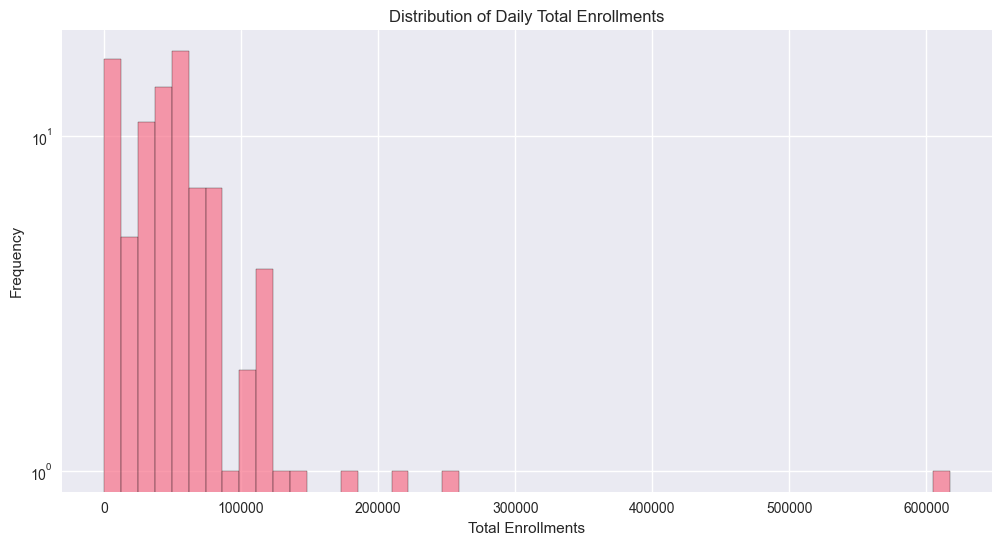

In [4]:
# Daily enrollment distributions
# Aggregate daily totals
daily_totals = df.groupby('date')[enrollment_cols].sum().reset_index()
daily_totals['total_enrollments'] = daily_totals[enrollment_cols].sum(axis=1)

print("Daily Enrollment Summary:")
print(daily_totals['total_enrollments'].describe())

# Plot daily enrollment distribution
plt.figure(figsize=(12, 6))
plt.hist(daily_totals['total_enrollments'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Daily Total Enrollments')
plt.xlabel('Total Enrollments')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

### Missing Values Detection and Visualization

Missing Values Summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


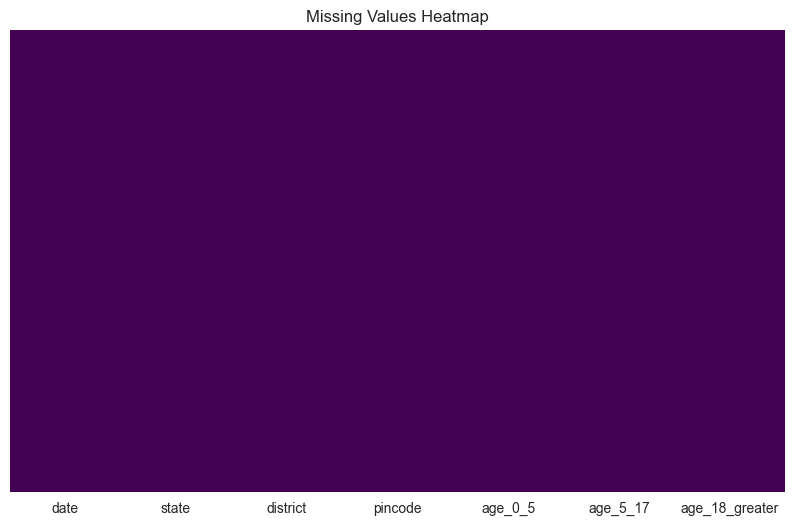

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

print("Missing Values Summary:")
print(missing_df[missing_df['Missing Values'] > 0])

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

### Outliers Detection

In [6]:
# Outlier detection using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers for each age group
for col in enrollment_cols:
    outliers, lb, ub = detect_outliers_iqr(df, col)
    print(f"\n{col} Outliers:")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {len(outliers)/len(df)*100:.2f}%")
    print(f"IQR bounds: [{lb:.1f}, {ub:.1f}]")
    print(f"Outlier range: Min={outliers[col].min()}, Max={outliers[col].max()}")


age_0_5 Outliers:
Number of outliers: 102013
Percentage of outliers: 10.14%
IQR bounds: [-2.0, 6.0]
Outlier range: Min=7, Max=2688

age_5_17 Outliers:
Number of outliers: 135765
Percentage of outliers: 13.50%
IQR bounds: [-1.5, 2.5]
Outlier range: Min=3, Max=1812

age_18_greater Outliers:
Number of outliers: 40225
Percentage of outliers: 4.00%
IQR bounds: [0.0, 0.0]
Outlier range: Min=1, Max=855


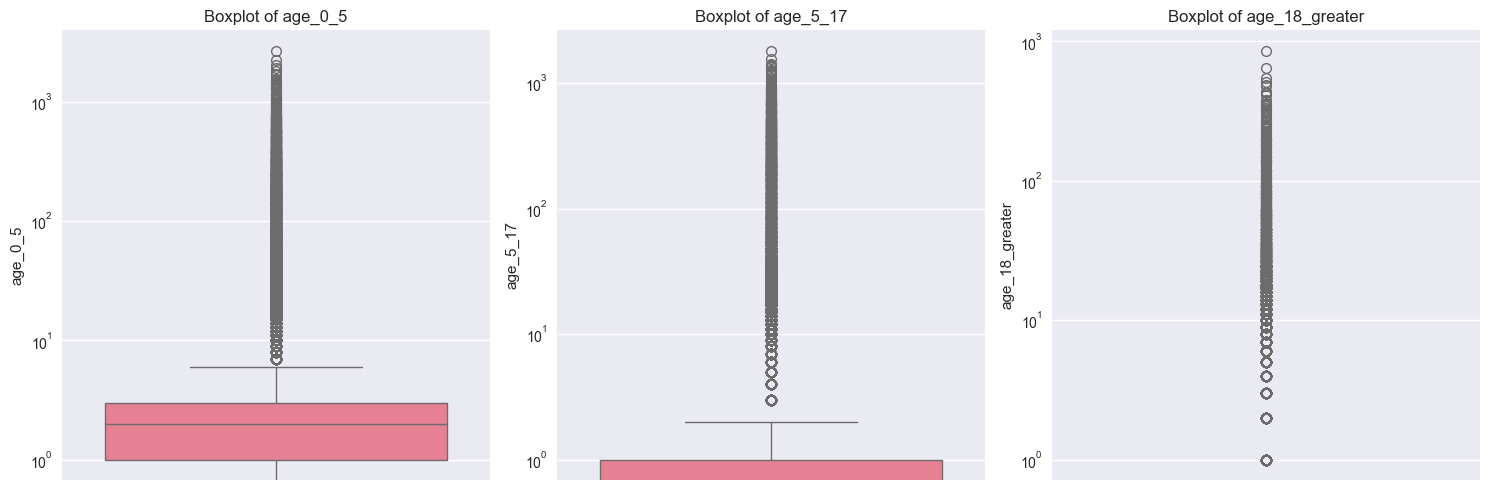

In [7]:
# Boxplots for outlier visualization
plt.figure(figsize=(15, 5))
for i, col in enumerate(enrollment_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.yscale('log')
plt.tight_layout()
plt.show()

### Anomalies Detection

Daily Enrollment Anomalies (|z-score| > 3):
Number of anomalous days: 1
Anomalous dates:
         date  total_enrollments   z_score
12 2025-07-01             616868  7.570538


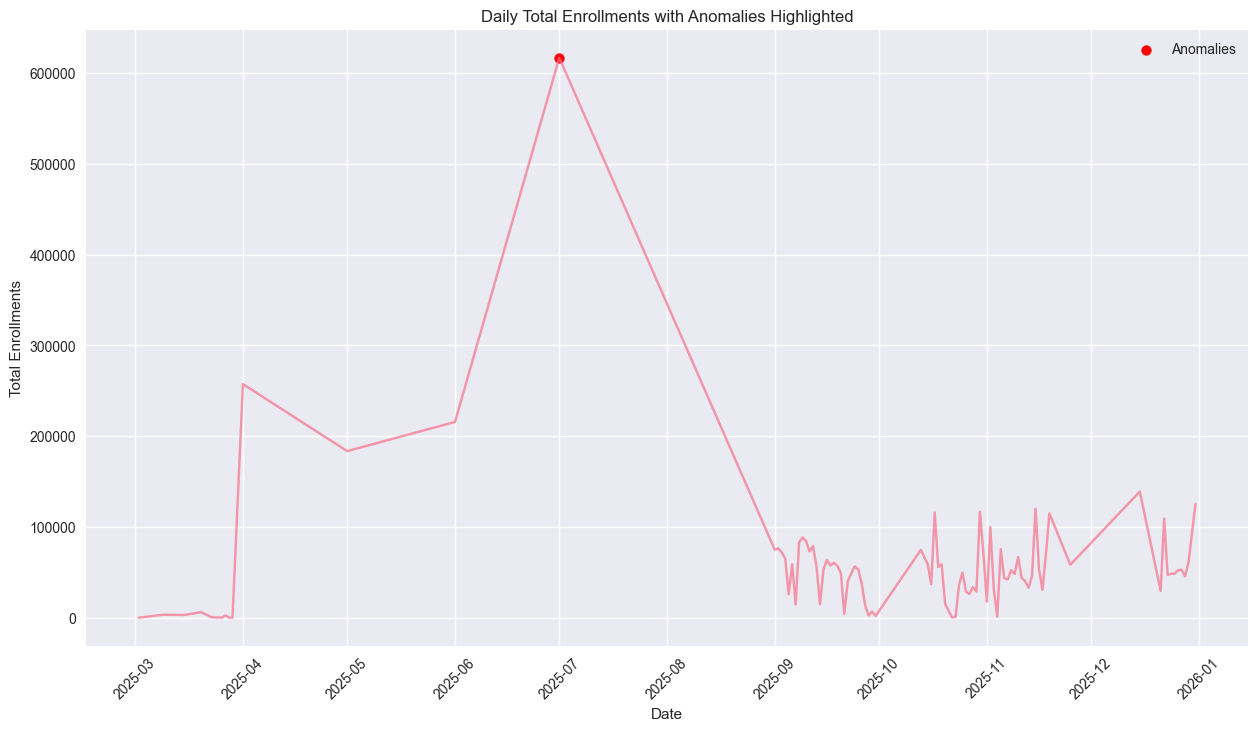

In [8]:
# Detect anomalies in daily totals (using z-score)
from scipy import stats

# Calculate z-scores for daily totals
daily_totals['z_score'] = stats.zscore(daily_totals['total_enrollments'])
anomalies = daily_totals[abs(daily_totals['z_score']) > 3]

print("Daily Enrollment Anomalies (|z-score| > 3):")
print(f"Number of anomalous days: {len(anomalies)}")
print("Anomalous dates:")
print(anomalies[['date', 'total_enrollments', 'z_score']].sort_values('z_score', ascending=False))

# Plot time series with anomalies highlighted
plt.figure(figsize=(15, 8))
plt.plot(daily_totals['date'], daily_totals['total_enrollments'], alpha=0.7)
plt.scatter(anomalies['date'], anomalies['total_enrollments'], color='red', s=50, label='Anomalies')
plt.title('Daily Total Enrollments with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Total Enrollments')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Summary Tables

In [9]:
# Total enrollments by state
state_totals = df.groupby('state')[enrollment_cols].sum().reset_index()
state_totals['total'] = state_totals[enrollment_cols].sum(axis=1)
state_totals = state_totals.sort_values('total', ascending=False)

print("Top 10 States by Total Enrollments:")
print(state_totals.head(10)[['state', 'total'] + enrollment_cols])

# Total enrollments by district
district_totals = df.groupby(['state', 'district'])[enrollment_cols].sum().reset_index()
district_totals['total'] = district_totals[enrollment_cols].sum(axis=1)
district_totals = district_totals.sort_values('total', ascending=False)

print("\nTop 10 Districts by Total Enrollments:")
print(district_totals.head(10)[['state', 'district', 'total'] + enrollment_cols])

Top 10 States by Total Enrollments:
             state    total  age_0_5  age_5_17  age_18_greater
44   Uttar Pradesh  1018629   521045    479682           17902
6            Bihar   609585   262875    334802           11908
27  Madhya Pradesh   493970   367990    116381            9599
49     West Bengal   375297   275391     91396            8510
28     Maharashtra   369139   278814     82116            8209
38       Rajasthan   348458   229780    113123            5555
16         Gujarat   280549   193031     71182           16336
5            Assam   230197   141235     66085           22877
23       Karnataka   223235   179262     33863           10110
40      Tamil Nadu   220789   182313     37227            1249

Top 10 Districts by Total Enrollments:
               state           district  total  age_0_5  age_5_17  \
28425    Maharashtra              Thane  43688    29092     13629   
6703           Bihar          Sitamarhi  42232    20679     18856   
43399  Uttar Pradesh    

In [13]:
# Age-group shares (overall)
total_by_age = df[enrollment_cols].sum()
age_shares = (total_by_age / total_by_age.sum()) * 100

print("Overall Age Group Shares:")
for age_group, share in age_shares.items():
    print(f"{age_group}: {share:.2f}%")

# Age-group shares by state
state_age_shares = df.groupby('state')[enrollment_cols].sum()
state_age_shares_pct = state_age_shares.div(state_age_shares.sum(axis=1), axis=0) * 100

print("\nAge Group Shares by State (Top 5 States):")
top_states = state_totals.head(5)['state']
print(state_age_shares_pct.loc[top_states].round(2))

Overall Age Group Shares:
age_0_5: 65.25%
age_5_17: 31.65%
age_18_greater: 3.10%

Age Group Shares by State (Top 5 States):
                age_0_5  age_5_17  age_18_greater
state                                            
Uttar Pradesh     51.15     47.09            1.76
Bihar             43.12     54.92            1.95
Madhya Pradesh    74.50     23.56            1.94
West Bengal       73.38     24.35            2.27
Maharashtra       75.53     22.25            2.22


### Visualizations

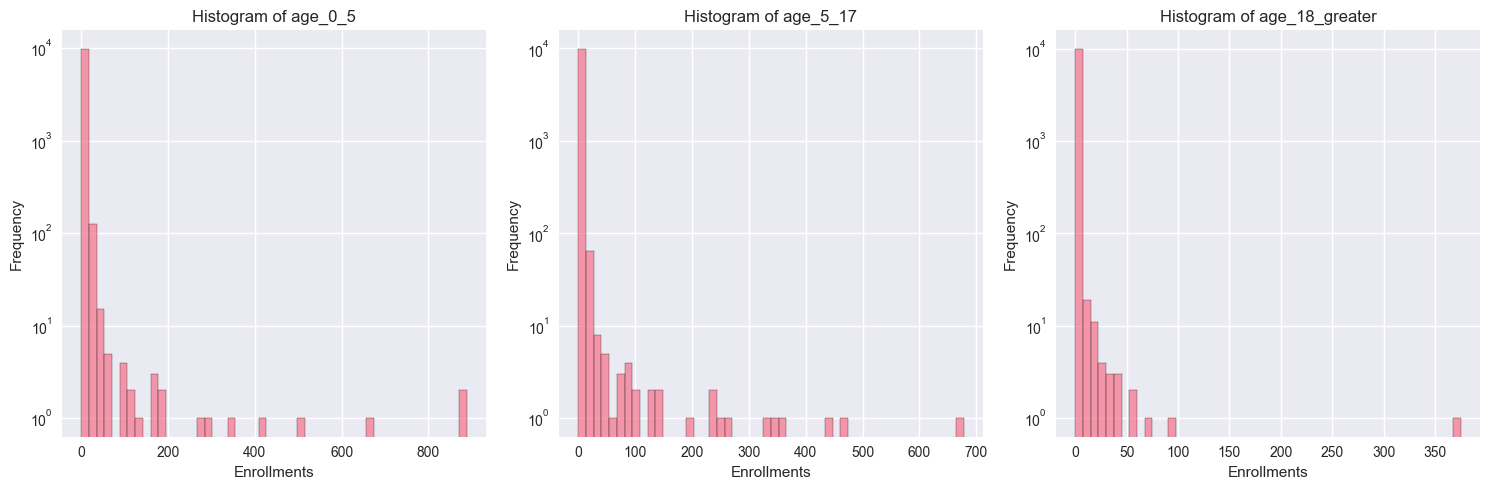

In [10]:
# Histograms for age groups
plt.figure(figsize=(15, 5))
for i, col in enumerate(enrollment_cols, 1):
    plt.subplot(1, 3, i)
    # Sample for histogram to handle large data
    sample_data = df[col].sample(min(10000, len(df)))
    plt.hist(sample_data, bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Enrollments')
    plt.ylabel('Frequency')
    plt.yscale('log')
plt.tight_layout()
plt.show()

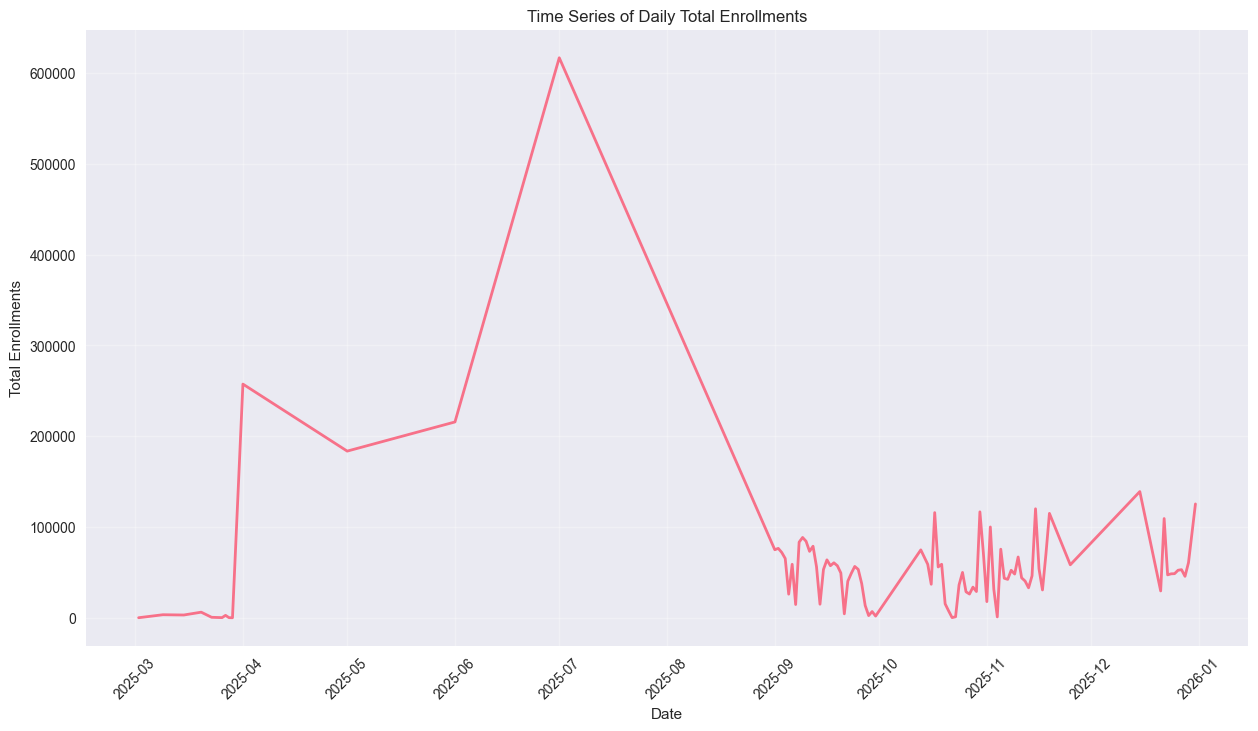

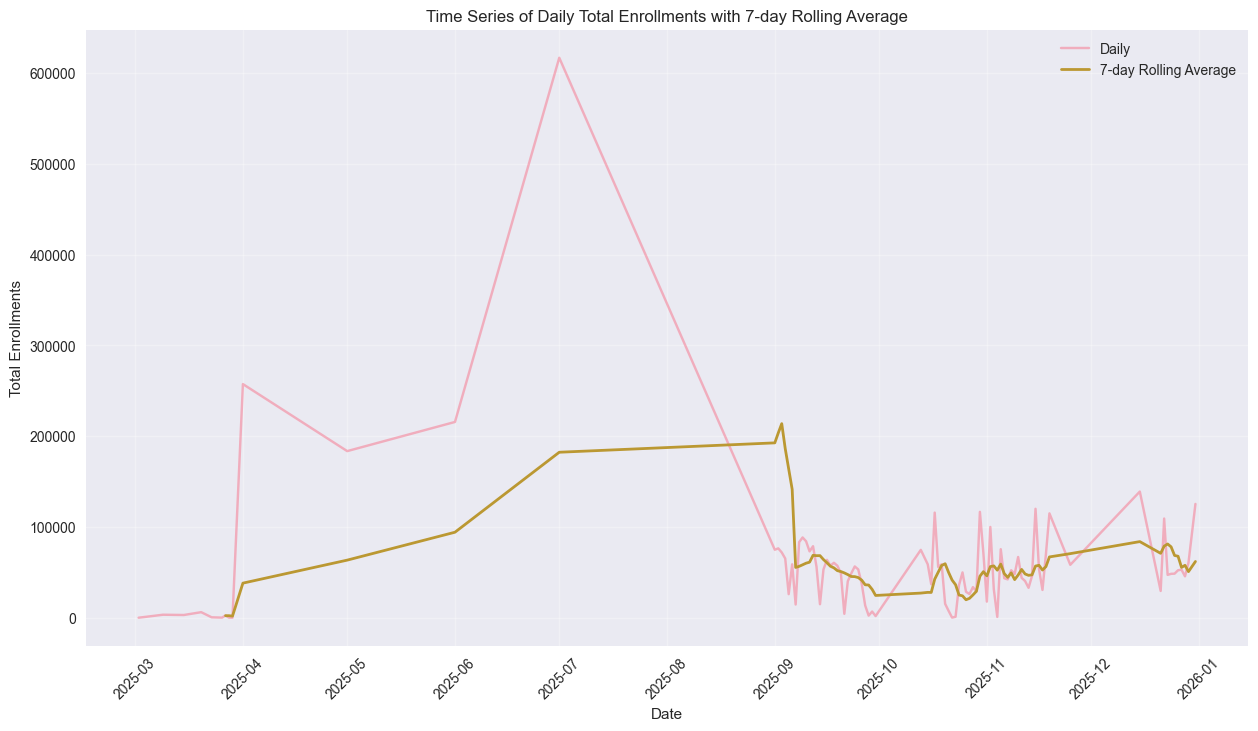

In [11]:
# Time series of overall enrollments
plt.figure(figsize=(15, 8))
plt.plot(daily_totals['date'], daily_totals['total_enrollments'], linewidth=2)
plt.title('Time Series of Daily Total Enrollments')
plt.xlabel('Date')
plt.ylabel('Total Enrollments')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# Rolling average to smooth the time series
daily_totals['rolling_avg'] = daily_totals['total_enrollments'].rolling(window=7).mean()
plt.figure(figsize=(15, 8))
plt.plot(daily_totals['date'], daily_totals['total_enrollments'], alpha=0.5, label='Daily')
plt.plot(daily_totals['date'], daily_totals['rolling_avg'], linewidth=2, label='7-day Rolling Average')
plt.title('Time Series of Daily Total Enrollments with 7-day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Total Enrollments')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 4000x1800 with 0 Axes>

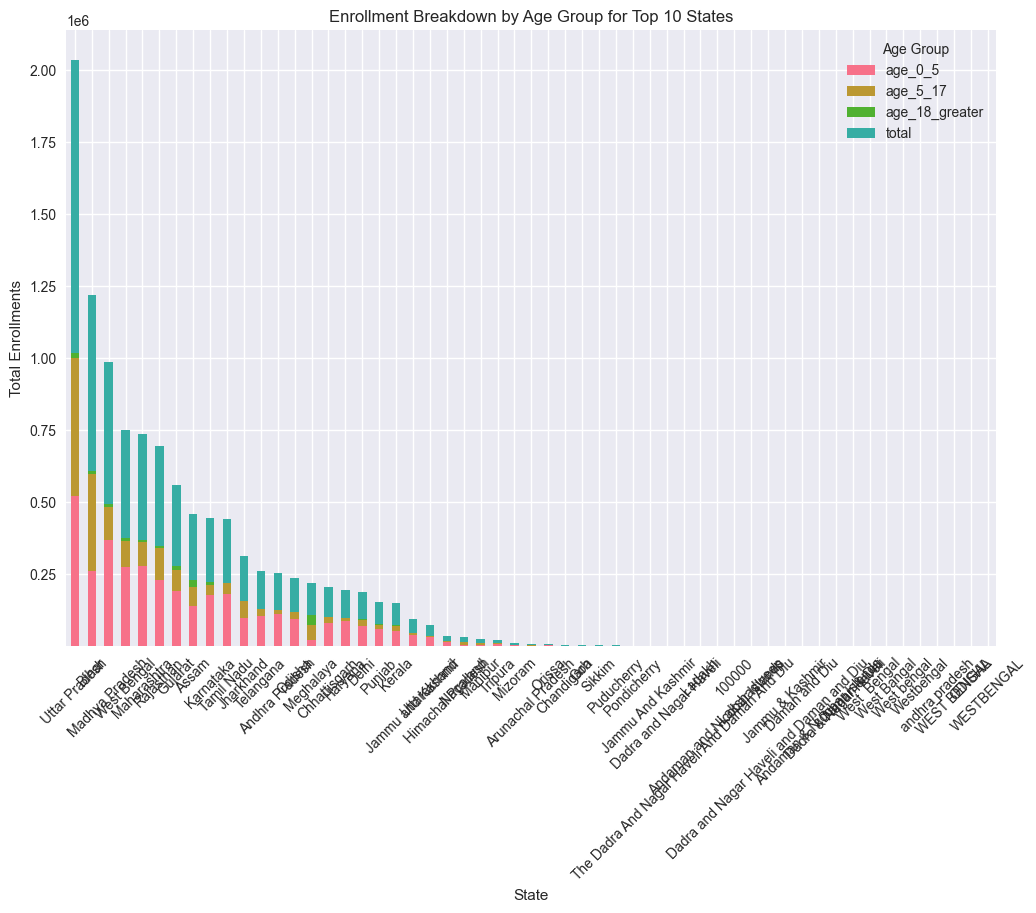

In [17]:
# State-wise enrollment comparison (top 10 states)
top_10_states = state_totals
plt.figure(figsize=(40,18))
top_10_states.set_index('state')[enrollment_cols + ['total']].plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Enrollment Breakdown by Age Group for Top 10 States')
plt.xlabel('State')
plt.ylabel('Total Enrollments')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.show()